In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

# Load dataset
data = pd.read_csv('../task_2_dataset/london_weather_clean.csv')

# Show basic info on dataset
print(data.info())
print(data.describe())
print(data.columns)

# Handle missing data
data = data.dropna()

# Data to learn from
X = data.drop(columns=['mean_temp'])

# Target data to predict
y = data['mean_temp']

# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardise features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

# Convert to tensors for pytorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15104 entries, 0 to 15103
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15104 non-null  int64  
 1   cloud_cover       15085 non-null  float64
 2   sunshine          15104 non-null  float64
 3   global_radiation  15085 non-null  float64
 4   max_temp          15104 non-null  float64
 5   mean_temp         15075 non-null  float64
 6   min_temp          15104 non-null  float64
 7   precipitation     15102 non-null  float64
 8   pressure          15100 non-null  float64
 9   snow_depth        13672 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB
None
               date   cloud_cover      sunshine  global_radiation  \
count  1.510400e+04  15085.000000  15104.000000      15085.000000   
mean   1.999583e+07      5.247000      4.398649        119.978787   
std    1.211468e+05      2.070516      4.034056         88.883210

In [2]:
# Class for weather dataset for manipulation
class WeatherDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# Create training and testing datasets from main dataset
train_dataset = WeatherDataset(X_train_tensor, y_train_tensor)
test_dataset = WeatherDataset(X_test_tensor, y_test_tensor)

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [3]:
import torch.nn as nn

# Define model
class PredictWeatherModel(nn.Module):
    def __init__(self, input_dim):
        super(PredictWeatherModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

# Init model
input_dim = X_train_tensor.shape[1]
model = PredictWeatherModel(input_dim)

In [4]:
import torch.optim as optim

# Loss + optimizer
# Mean squared error for regression
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
# Training loop


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

num_epochs = 10
train_losses, val_losses = [], []


def train_base_model (num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X, y in train_loader:
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Evaluate Model
        # Validation
        model.eval()
        predictions=[]
        actuals=[]
        running_loss = 0.0
        with torch.no_grad():
            for X, y in test_loader:
                output = model(X)
                predictions.extend(output.cpu().numpy().flatten())
                actuals.extend(y.cpu().numpy().flatten())
                loss = criterion(output, y)
                running_loss += loss.item()
            val_loss = running_loss / len(test_loader.dataset)
            val_losses.append(val_loss)
            mse = mean_squared_error(actuals, predictions)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(actuals, predictions)
            r2 = r2_score(actuals, predictions)

            print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}-RMSE: {rmse:.4f}-MAE: {mae:.4f}-R2: {r2:.4f}")

train_base_model(num_epochs)

Epoch 1/10 - Training Loss: 1.0492 - Validation Loss: 0.1008-RMSE: 1.7913-MAE: 1.4149-R2: 0.9015
Epoch 2/10 - Training Loss: 0.0602 - Validation Loss: 0.0403-RMSE: 1.1334-MAE: 0.8898-R2: 0.9606
Epoch 3/10 - Training Loss: 0.0316 - Validation Loss: 0.0291-RMSE: 0.9654-MAE: 0.7461-R2: 0.9714
Epoch 4/10 - Training Loss: 0.0265 - Validation Loss: 0.0280-RMSE: 0.9469-MAE: 0.7242-R2: 0.9725
Epoch 5/10 - Training Loss: 0.0253 - Validation Loss: 0.0267-RMSE: 0.9226-MAE: 0.7070-R2: 0.9739
Epoch 6/10 - Training Loss: 0.0246 - Validation Loss: 0.0254-RMSE: 0.8999-MAE: 0.6973-R2: 0.9752
Epoch 7/10 - Training Loss: 0.0244 - Validation Loss: 0.0271-RMSE: 0.9288-MAE: 0.7096-R2: 0.9735
Epoch 8/10 - Training Loss: 0.0244 - Validation Loss: 0.0249-RMSE: 0.8908-MAE: 0.6867-R2: 0.9757
Epoch 9/10 - Training Loss: 0.0237 - Validation Loss: 0.0248-RMSE: 0.8882-MAE: 0.6824-R2: 0.9758
Epoch 10/10 - Training Loss: 0.0237 - Validation Loss: 0.0248-RMSE: 0.8873-MAE: 0.6807-R2: 0.9758



Final Model Performance:
Root Mean Square Error: 0.89°C
Mean Absolute Error: 0.68°C
R² Score: 0.9758

Sample Predictions vs Actual Values:
Predicted: 9.24°C, Actual: 8.20°C, Difference: 1.04°C
Predicted: 15.76°C, Actual: 16.10°C, Difference: -0.34°C
Predicted: 8.79°C, Actual: 8.40°C, Difference: 0.39°C
Predicted: 9.22°C, Actual: 10.20°C, Difference: -0.98°C
Predicted: 19.65°C, Actual: 19.80°C, Difference: -0.15°C

Error Statistics:
Average Error: 0.04°C
Standard Deviation of Error: 0.89°C
Maximum Overprediction: 3.75°C
Maximum Underprediction: -4.44°C


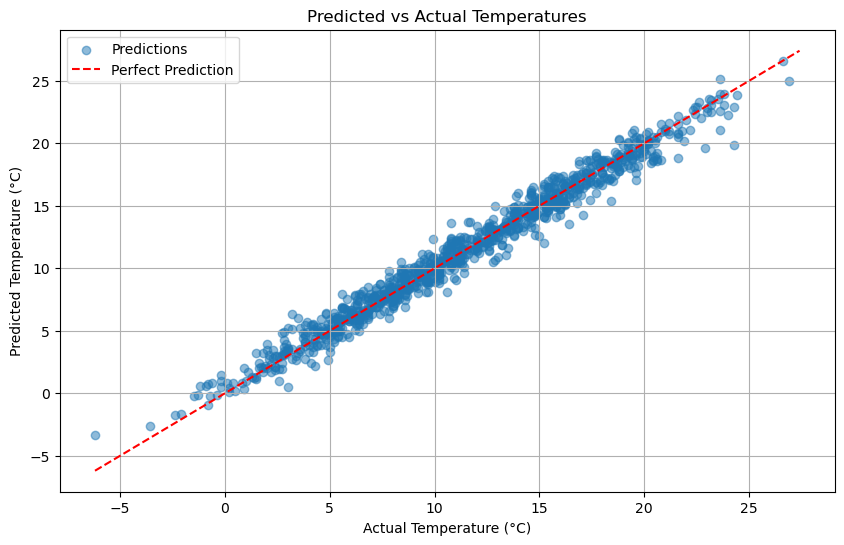

In [6]:

def make_predictions(model, test_loader):
    model.eval()
    all_predictions = []
    actual_values = []

    # Make predictions without calculating gradients
    with torch.no_grad():
        for X, y in test_loader:
            outputs = model(X)
            # Store predictions and actual values
            all_predictions.extend(outputs.cpu().numpy().flatten())
            actual_values.extend(y.cpu().numpy().flatten())

    return np.array(all_predictions), np.array(actual_values)


predictions, actuals = make_predictions(model, test_loader)


def analyze_predictions(predictions, actuals):

    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    print("\nFinal Model Performance:")
    print(f"Root Mean Square Error: {rmse:.2f}°C")
    print(f"Mean Absolute Error: {mae:.2f}°C")
    print(f"R² Score: {r2:.4f}")


    print("\nSample Predictions vs Actual Values:")
    for i in range(5):  # Show first 5 predictions
        print(f"Predicted: {predictions[i]:.2f}°C, Actual: {actuals[i]:.2f}°C, "
              f"Difference: {(predictions[i] - actuals[i]):.2f}°C")


    errors = predictions - actuals
    print(f"\nError Statistics:")
    print(f"Average Error: {np.mean(errors):.2f}°C")
    print(f"Standard Deviation of Error: {np.std(errors):.2f}°C")
    print(f"Maximum Overprediction: {np.max(errors):.2f}°C")
    print(f"Maximum Underprediction: {np.min(errors):.2f}°C")


analyze_predictions(predictions, actuals)

#Visualisation
import matplotlib.pyplot as plt

def plot_predictions(predictions, actuals, num_points=1000):
    plt.figure(figsize=(10, 6))

    # Plot the first num_points predictions
    plt.scatter(actuals[:num_points], predictions[:num_points],
                alpha=0.5, label='Predictions')

    # Plot perfect prediction line
    min_val = min(min(predictions), min(actuals))
    max_val = max(max(predictions), max(actuals))
    plt.plot([min_val, max_val], [min_val, max_val],
             'r--', label='Perfect Prediction')

    plt.xlabel('Actual Temperature (°C)')
    plt.ylabel('Predicted Temperature (°C)')
    plt.title('Predicted vs Actual Temperatures')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize our predictions
plot_predictions(predictions, actuals)

In [7]:
num_epochs = 5
train_base_model(num_epochs)


Epoch 1/5 - Training Loss: 0.0238 - Validation Loss: 0.0248-RMSE: 0.8873-MAE: 0.6899-R2: 0.9758
Epoch 2/5 - Training Loss: 0.0236 - Validation Loss: 0.0259-RMSE: 0.9067-MAE: 0.6991-R2: 0.9748
Epoch 3/5 - Training Loss: 0.0234 - Validation Loss: 0.0250-RMSE: 0.8902-MAE: 0.6878-R2: 0.9757
Epoch 4/5 - Training Loss: 0.0233 - Validation Loss: 0.0246-RMSE: 0.8839-MAE: 0.6814-R2: 0.9760
Epoch 5/5 - Training Loss: 0.0233 - Validation Loss: 0.0259-RMSE: 0.9066-MAE: 0.6961-R2: 0.9748



Final Model Performance:
Root Mean Square Error: 0.91°C
Mean Absolute Error: 0.70°C
R² Score: 0.9748

Sample Predictions vs Actual Values:
Predicted: 8.96°C, Actual: 8.20°C, Difference: 0.76°C
Predicted: 15.82°C, Actual: 16.10°C, Difference: -0.28°C
Predicted: 8.65°C, Actual: 8.40°C, Difference: 0.25°C
Predicted: 8.67°C, Actual: 10.20°C, Difference: -1.53°C
Predicted: 19.24°C, Actual: 19.80°C, Difference: -0.56°C

Error Statistics:
Average Error: -0.22°C
Standard Deviation of Error: 0.88°C
Maximum Overprediction: 3.30°C
Maximum Underprediction: -4.23°C


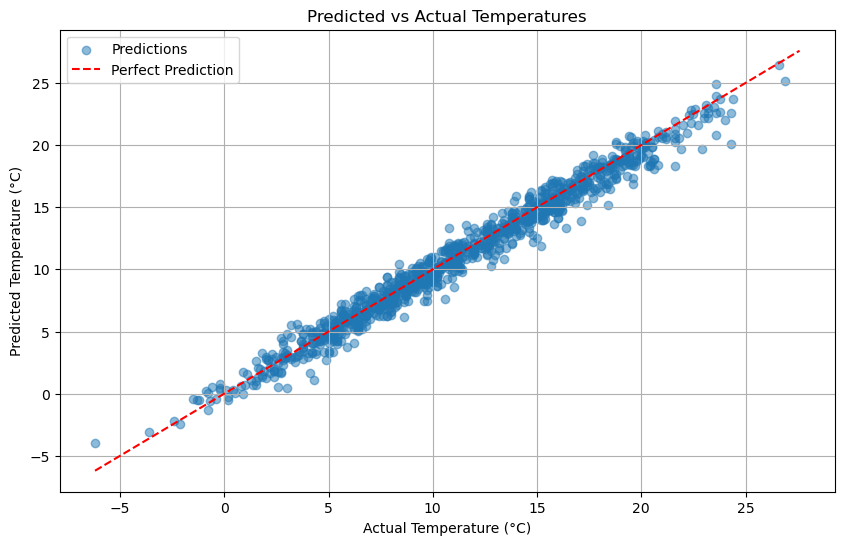

In [8]:
predictions, actuals = make_predictions(model, test_loader)
analyze_predictions(predictions, actuals)
plot_predictions(predictions, actuals)

In [9]:
num_epochs = 30
train_base_model(num_epochs)

Epoch 1/30 - Training Loss: 0.0231 - Validation Loss: 0.0263-RMSE: 0.9147-MAE: 0.6980-R2: 0.9743
Epoch 2/30 - Training Loss: 0.0227 - Validation Loss: 0.0252-RMSE: 0.8948-MAE: 0.6917-R2: 0.9754
Epoch 3/30 - Training Loss: 0.0229 - Validation Loss: 0.0246-RMSE: 0.8839-MAE: 0.6773-R2: 0.9760
Epoch 4/30 - Training Loss: 0.0229 - Validation Loss: 0.0251-RMSE: 0.8934-MAE: 0.6866-R2: 0.9755
Epoch 5/30 - Training Loss: 0.0228 - Validation Loss: 0.0243-RMSE: 0.8783-MAE: 0.6720-R2: 0.9763
Epoch 6/30 - Training Loss: 0.0228 - Validation Loss: 0.0242-RMSE: 0.8759-MAE: 0.6728-R2: 0.9765
Epoch 7/30 - Training Loss: 0.0226 - Validation Loss: 0.0250-RMSE: 0.8898-MAE: 0.6805-R2: 0.9757
Epoch 8/30 - Training Loss: 0.0229 - Validation Loss: 0.0245-RMSE: 0.8823-MAE: 0.6755-R2: 0.9761
Epoch 9/30 - Training Loss: 0.0223 - Validation Loss: 0.0246-RMSE: 0.8841-MAE: 0.6762-R2: 0.9760
Epoch 10/30 - Training Loss: 0.0225 - Validation Loss: 0.0239-RMSE: 0.8708-MAE: 0.6702-R2: 0.9767
Epoch 11/30 - Training Loss: 


Final Model Performance:
Root Mean Square Error: 0.90°C
Mean Absolute Error: 0.69°C
R² Score: 0.9754

Sample Predictions vs Actual Values:
Predicted: 9.42°C, Actual: 8.20°C, Difference: 1.22°C
Predicted: 15.86°C, Actual: 16.10°C, Difference: -0.24°C
Predicted: 8.84°C, Actual: 8.40°C, Difference: 0.44°C
Predicted: 9.41°C, Actual: 10.20°C, Difference: -0.79°C
Predicted: 19.77°C, Actual: 19.80°C, Difference: -0.03°C

Error Statistics:
Average Error: 0.19°C
Standard Deviation of Error: 0.88°C
Maximum Overprediction: 4.12°C
Maximum Underprediction: -3.81°C


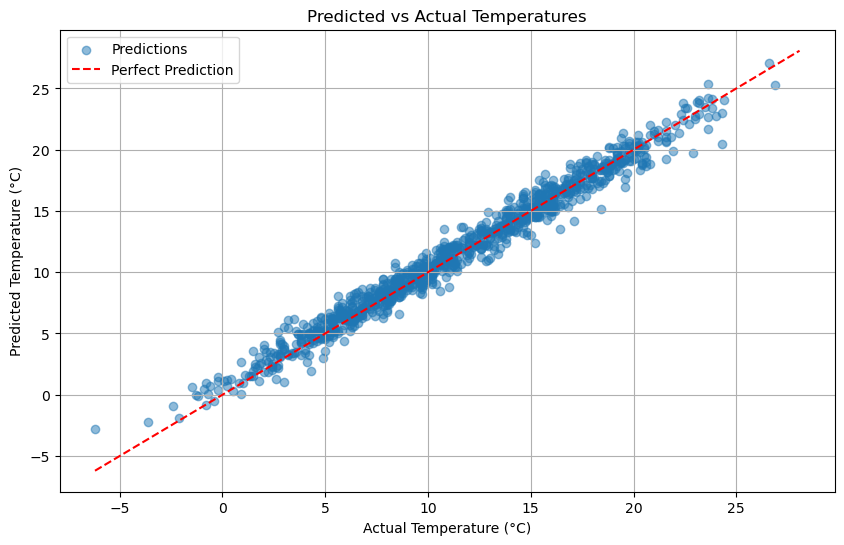

In [10]:
predictions, actuals = make_predictions(model, test_loader)
analyze_predictions(predictions, actuals)
plot_predictions(predictions, actuals)

In [11]:
# Improve model
# Implement Dropout, Batch Normalisation , more layers

class WeatherModel(nn.Module):
    def __init__(self, input_dim):
        super(WeatherModel, self).__init__()

        # First layer
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # Second layer
        self.layer2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # Third layer
        self.layer3 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        # Output layer
        self.output = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.output(x)
        return x

model = WeatherModel(input_dim=X_train_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.01)




In [12]:
#Training for Improved model

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for X, y in train_loader:
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    predictions = []
    actuals = []
    val_loss = 0.0

    with torch.no_grad():
        for X, y in test_loader:
            outputs = model(X)
            predictions.extend(outputs.cpu().numpy().flatten())
            actuals.extend(y.cpu().numpy().flatten())
            loss = criterion(outputs, y)
            val_loss += loss.item()

    val_loss = val_loss / len(test_loader.dataset)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)



    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}-RMSE: {rmse:.4f}-MAE: {mae:.4f}-R2: {r2:.4f}")

Epoch 1/20 - Training Loss: 1.3232 - Validation Loss: 0.0420-RMSE: 1.1545-MAE: 0.8787-R2: 0.9591
Epoch 2/20 - Training Loss: 0.1096 - Validation Loss: 0.0471-RMSE: 1.2246-MAE: 0.9499-R2: 0.9540
Epoch 3/20 - Training Loss: 0.1075 - Validation Loss: 0.0525-RMSE: 1.2929-MAE: 0.9921-R2: 0.9487
Epoch 4/20 - Training Loss: 0.0972 - Validation Loss: 0.0634-RMSE: 1.4194-MAE: 1.1088-R2: 0.9382
Epoch 5/20 - Training Loss: 0.0932 - Validation Loss: 0.0441-RMSE: 1.1843-MAE: 0.9014-R2: 0.9570
Epoch 6/20 - Training Loss: 0.0897 - Validation Loss: 0.0486-RMSE: 1.2446-MAE: 0.9337-R2: 0.9525
Epoch 7/20 - Training Loss: 0.0927 - Validation Loss: 0.0368-RMSE: 1.0815-MAE: 0.8225-R2: 0.9641
Epoch 8/20 - Training Loss: 0.0927 - Validation Loss: 0.0362-RMSE: 1.0737-MAE: 0.8131-R2: 0.9646
Epoch 9/20 - Training Loss: 0.0888 - Validation Loss: 0.0296-RMSE: 0.9713-MAE: 0.7331-R2: 0.9710
Epoch 10/20 - Training Loss: 0.0904 - Validation Loss: 0.0343-RMSE: 1.0442-MAE: 0.7905-R2: 0.9665
Epoch 11/20 - Training Loss: 


Final Model Performance:
Root Mean Square Error: 0.98°C
Mean Absolute Error: 0.74°C
R² Score: 0.9705

Sample Predictions vs Actual Values:
Predicted: 9.07°C, Actual: 8.20°C, Difference: 0.87°C
Predicted: 15.45°C, Actual: 16.10°C, Difference: -0.65°C
Predicted: 8.70°C, Actual: 8.40°C, Difference: 0.30°C
Predicted: 8.83°C, Actual: 10.20°C, Difference: -1.37°C
Predicted: 19.05°C, Actual: 19.80°C, Difference: -0.75°C

Error Statistics:
Average Error: -0.03°C
Standard Deviation of Error: 0.98°C
Maximum Overprediction: 5.68°C
Maximum Underprediction: -3.95°C


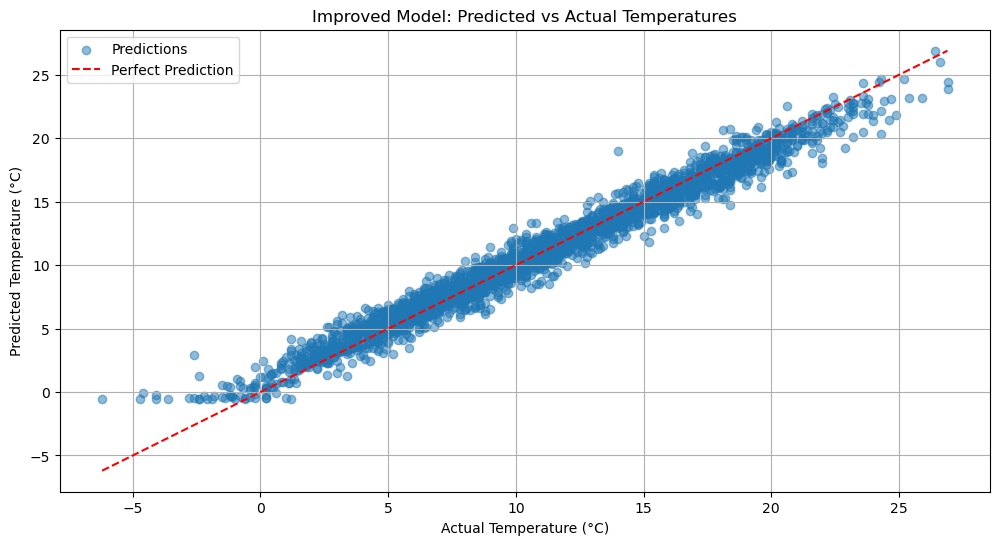

In [13]:
def plot_temperature_predictions_improved(predictions, actuals):
    plt.figure(figsize=(12, 6))

    # Create scatter plot
    plt.scatter(actuals, predictions, alpha=0.5, label='Predictions')
    min_temp = min(min(predictions), min(actuals))
    max_temp = max(max(predictions), max(actuals))
    plt.plot([min_temp, max_temp], [min_temp, max_temp],
             'r--', label='Perfect Prediction')

    # Labels and title
    plt.xlabel('Actual Temperature (°C)')
    plt.ylabel('Predicted Temperature (°C)')
    plt.title('Improved Model: Predicted vs Actual Temperatures')
    plt.legend()
    plt.grid(True)
    plt.show()

#Predictions
predictions, actuals = make_predictions(model, test_loader)
analyze_predictions(predictions, actuals)
plot_temperature_predictions_improved(predictions, actuals)

In [14]:
# Hyperparamater Optimization

Training with LR=0.01, Batch Size=16


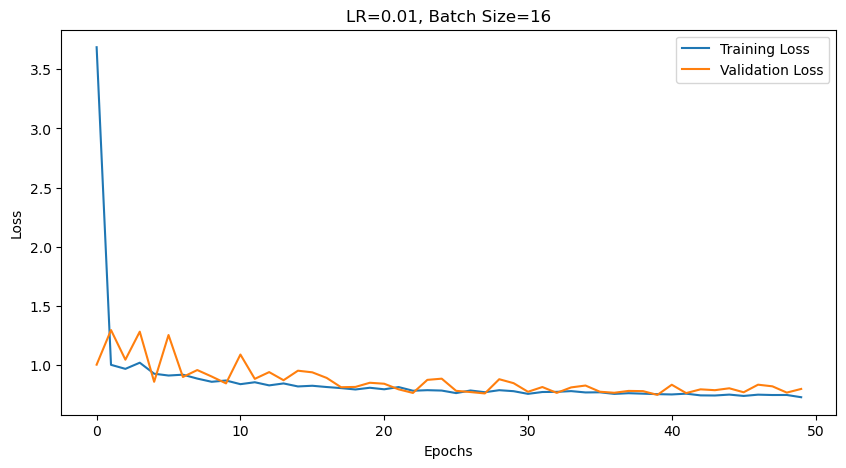

Training with LR=0.01, Batch Size=32


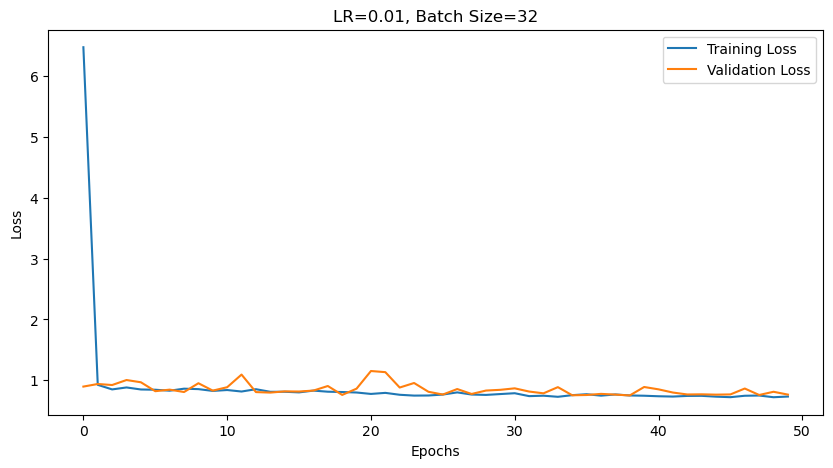

Training with LR=0.001, Batch Size=16


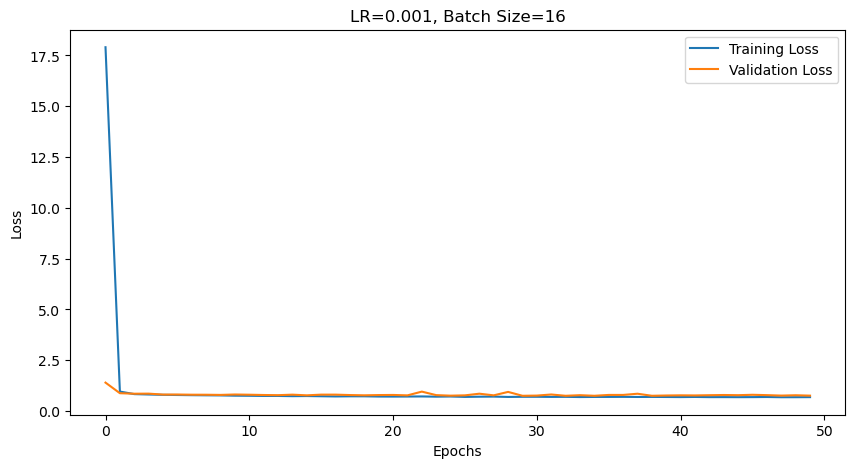

Training with LR=0.001, Batch Size=32


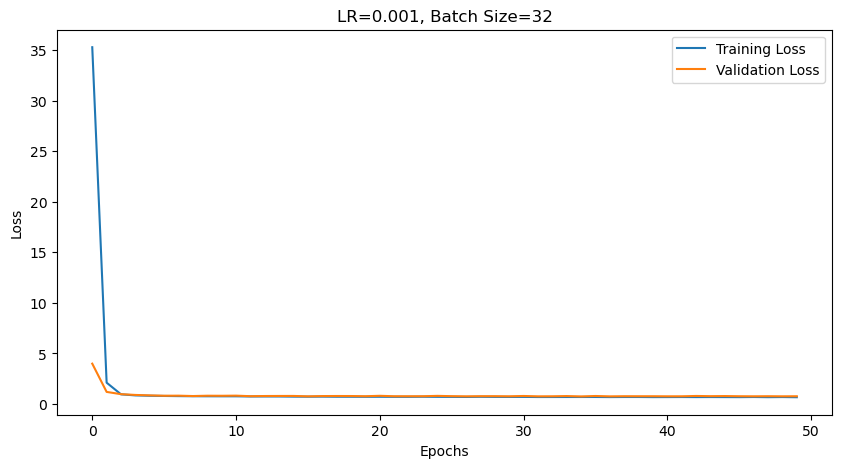

LR=0.01, Batch Size=16: Final Validation Loss=0.7974
LR=0.01, Batch Size=32: Final Validation Loss=0.7651
LR=0.001, Batch Size=16: Final Validation Loss=0.7550
LR=0.001, Batch Size=32: Final Validation Loss=0.7659


In [15]:
# Function to train and evaluate the model
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        # Training loop
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))
    
    return train_losses, val_losses

# Define hyperparameter grid
learning_rates = [0.01, 0.001]
batch_sizes = [16, 32]
epochs = 50

results = {}

# Loop over hyperparameter combinations
for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Training with LR={lr}, Batch Size={batch_size}")

        # Update DataLoader for batch size
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Initialize model, loss, and optimizer
        model = PredictWeatherModel(input_dim)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Train model
        train_losses, val_losses = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, epochs)
        
        # Store results
        results[(lr, batch_size)] = (train_losses, val_losses)

        # Plot Loss vs. Epochs
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label="Training Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.title(f"LR={lr}, Batch Size={batch_size}")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

# Compare results for final validation loss
final_losses = {key: val[-1] for key, (_, val) in results.items()}
for key, loss in final_losses.items():
    print(f"LR={key[0]}, Batch Size={key[1]}: Final Validation Loss={loss:.4f}")

In [16]:

import torch.nn as nn

# Define model with configurable dropout and layers
class ConfigurableWeatherModel(nn.Module):
    def __init__(self, input_dim, hidden_layers, dropout_rate):
        """
        Parameters:
        - input_dim: Number of input features.
        - hidden_layers: List of integers where each value represents the number of units in that layer.
        - dropout_rate: Dropout probability.
        """
        super(ConfigurableWeatherModel, self).__init__()
        
        # Create layers dynamically
        layers = []
        prev_dim = input_dim
        
        for units in hidden_layers:
            layers.append(nn.Linear(prev_dim, units))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = units
        
        # Output layer (1 unit for regression task)
        layers.append(nn.Linear(prev_dim, 1))
        
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


Training with LR=0.01, Batch Size=16, Dropout=0.2, Layers=[64, 32]


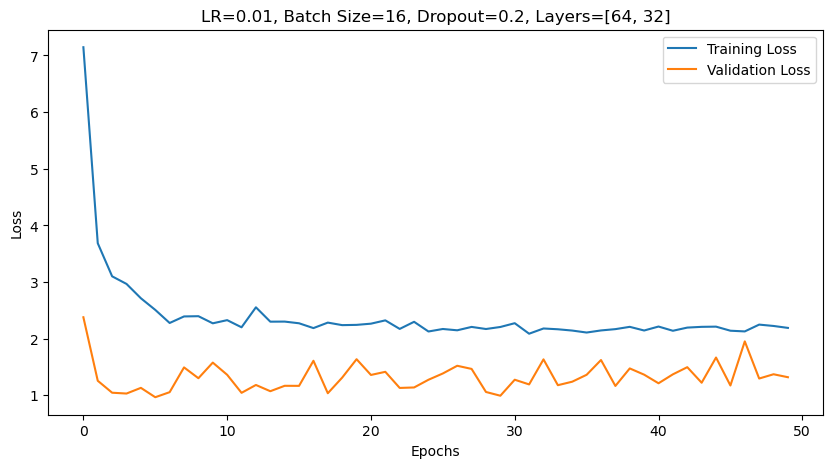

Training with LR=0.01, Batch Size=16, Dropout=0.2, Layers=[128, 64, 32]


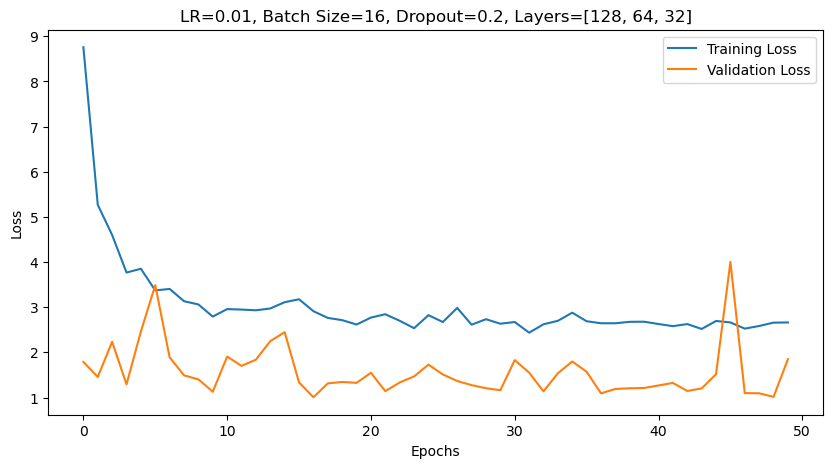

Training with LR=0.01, Batch Size=16, Dropout=0.5, Layers=[64, 32]


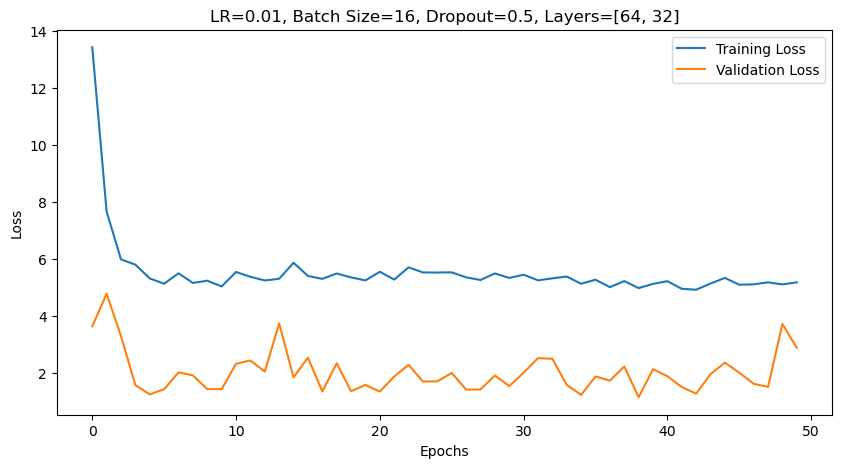

Training with LR=0.01, Batch Size=16, Dropout=0.5, Layers=[128, 64, 32]


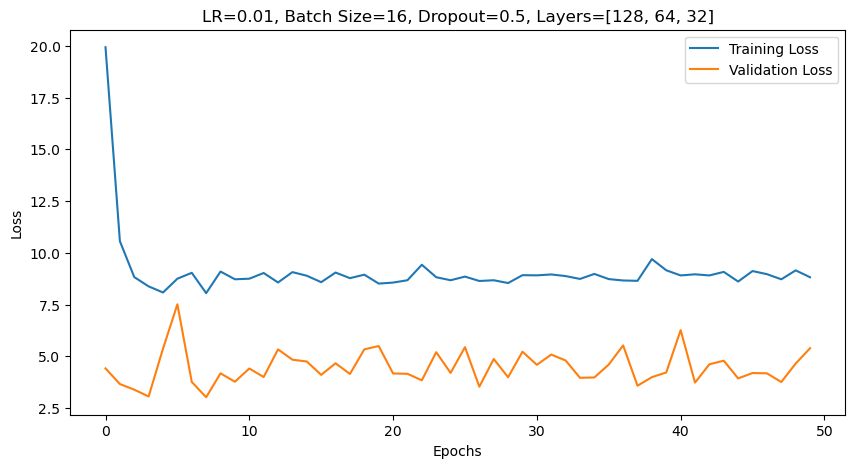

Training with LR=0.01, Batch Size=32, Dropout=0.2, Layers=[64, 32]


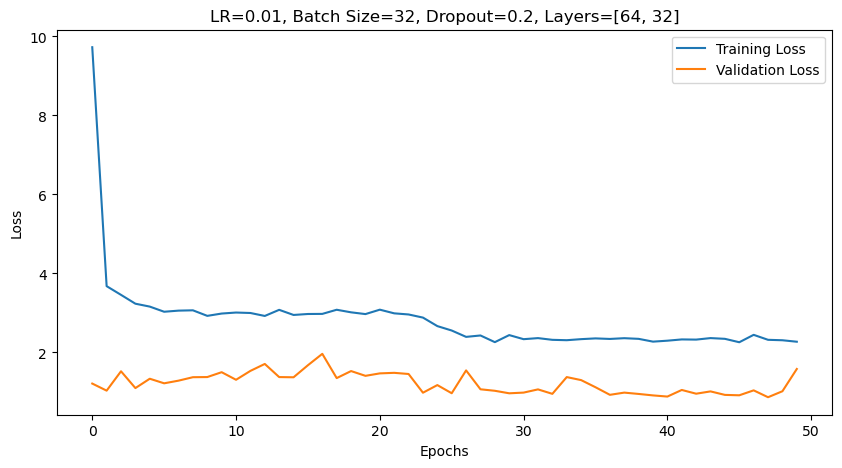

Training with LR=0.01, Batch Size=32, Dropout=0.2, Layers=[128, 64, 32]


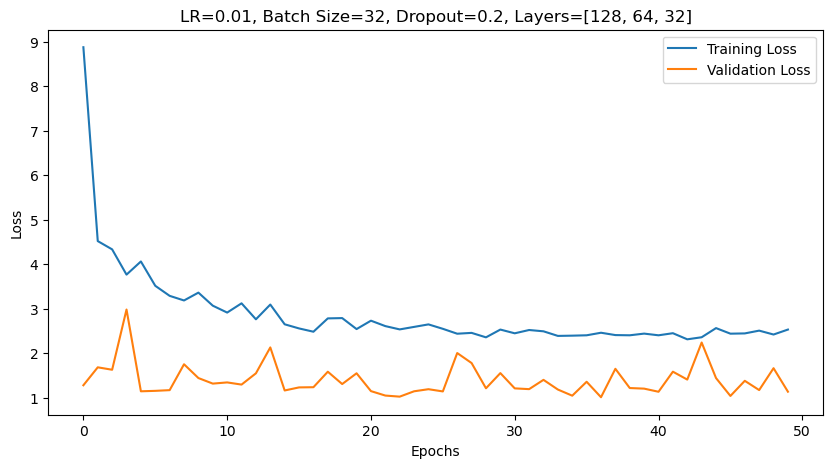

Training with LR=0.01, Batch Size=32, Dropout=0.5, Layers=[64, 32]


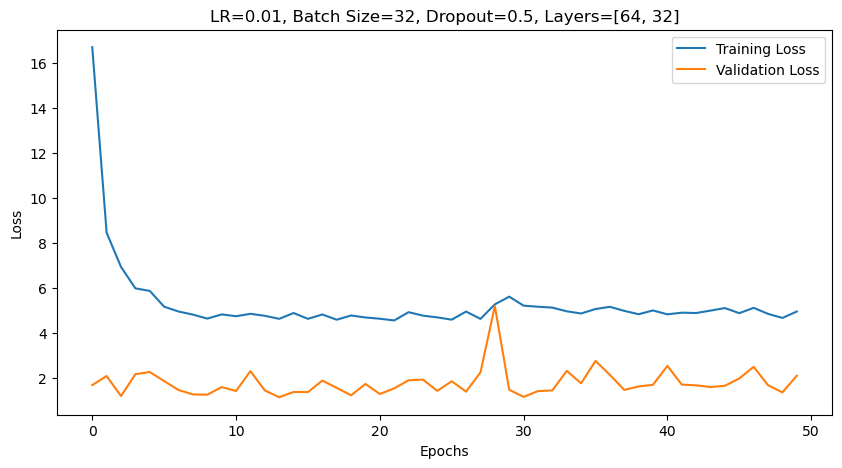

Training with LR=0.01, Batch Size=32, Dropout=0.5, Layers=[128, 64, 32]


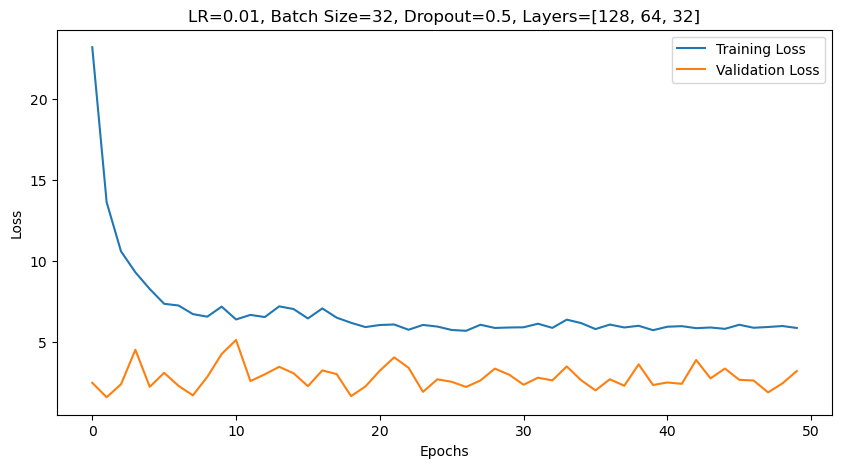

Training with LR=0.001, Batch Size=16, Dropout=0.2, Layers=[64, 32]


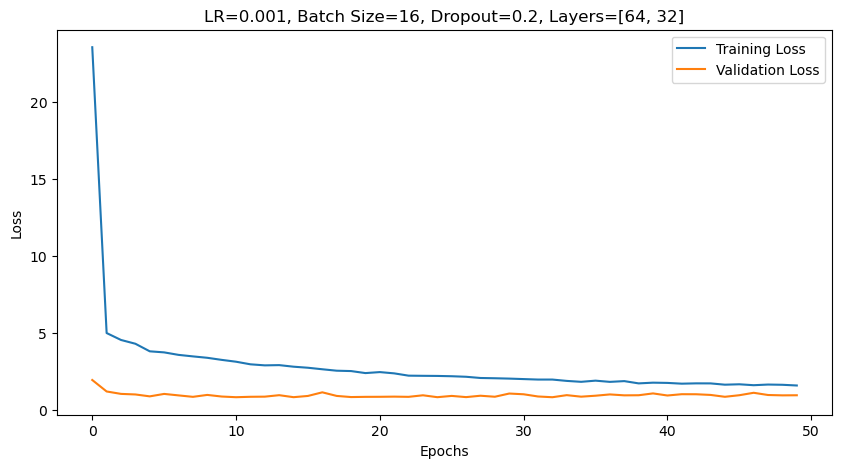

Training with LR=0.001, Batch Size=16, Dropout=0.2, Layers=[128, 64, 32]


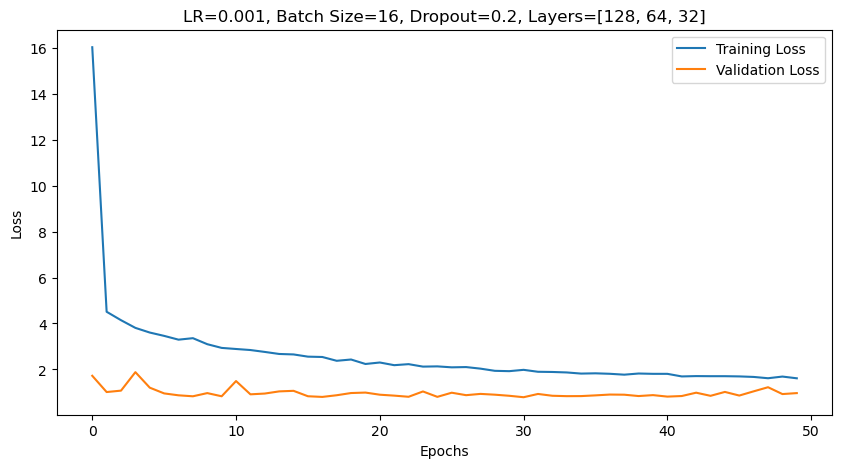

Training with LR=0.001, Batch Size=16, Dropout=0.5, Layers=[64, 32]


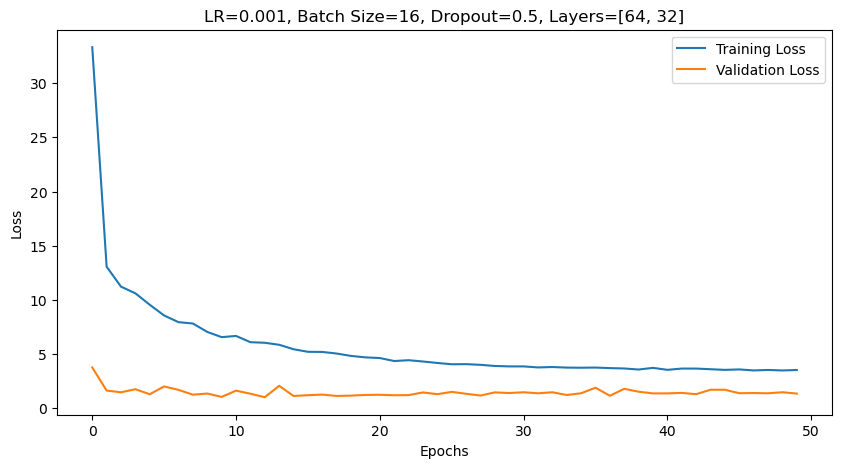

Training with LR=0.001, Batch Size=16, Dropout=0.5, Layers=[128, 64, 32]


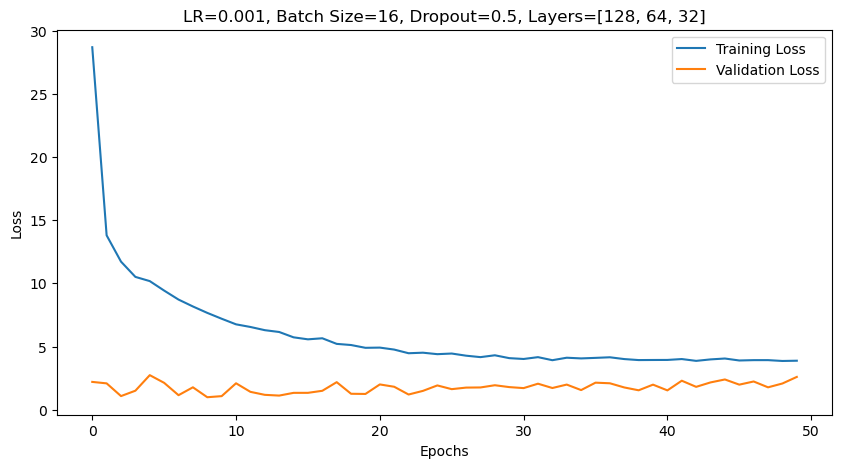

Training with LR=0.001, Batch Size=32, Dropout=0.2, Layers=[64, 32]


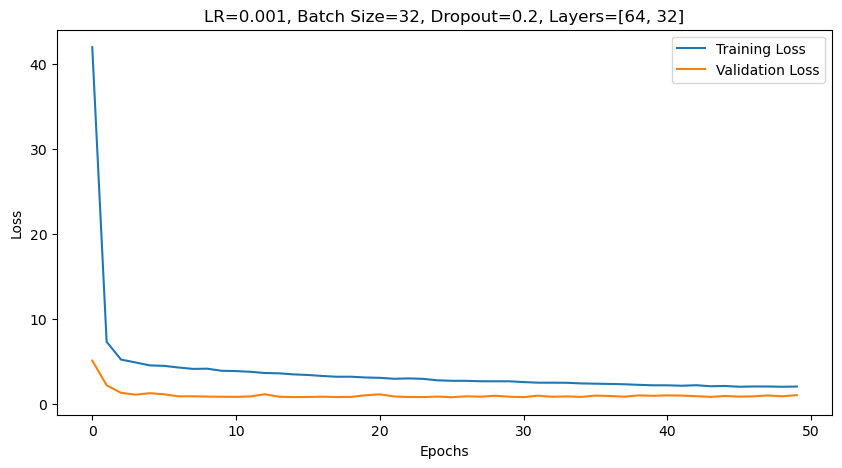

Training with LR=0.001, Batch Size=32, Dropout=0.2, Layers=[128, 64, 32]


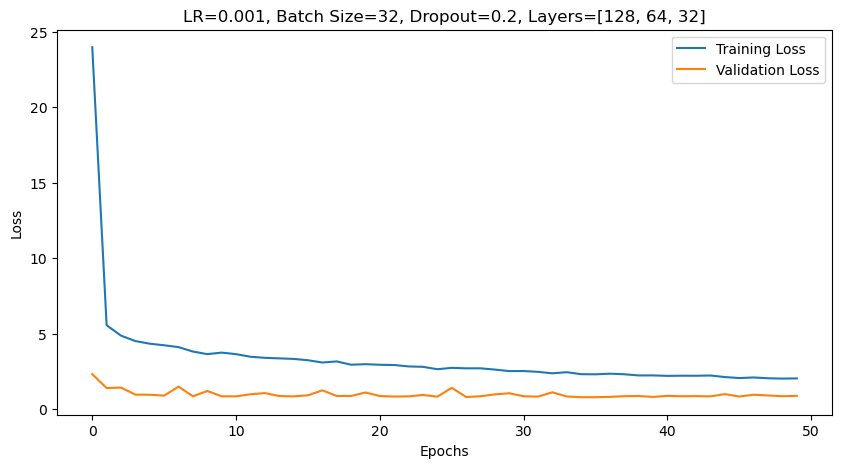

Training with LR=0.001, Batch Size=32, Dropout=0.5, Layers=[64, 32]


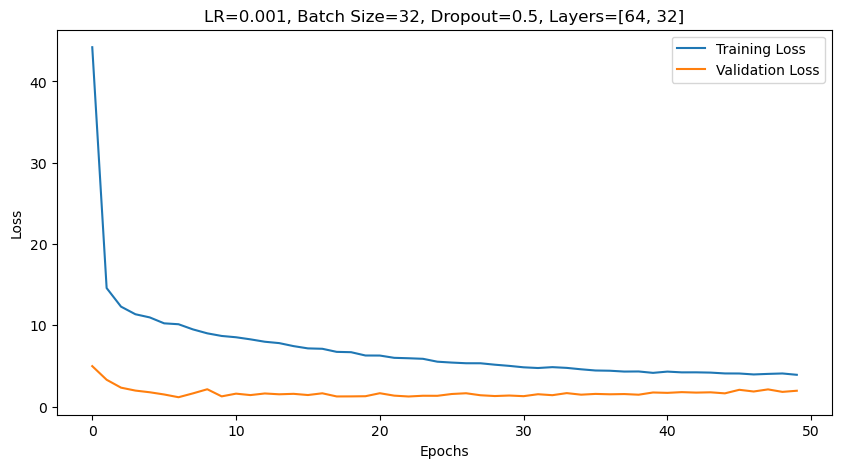

Training with LR=0.001, Batch Size=32, Dropout=0.5, Layers=[128, 64, 32]


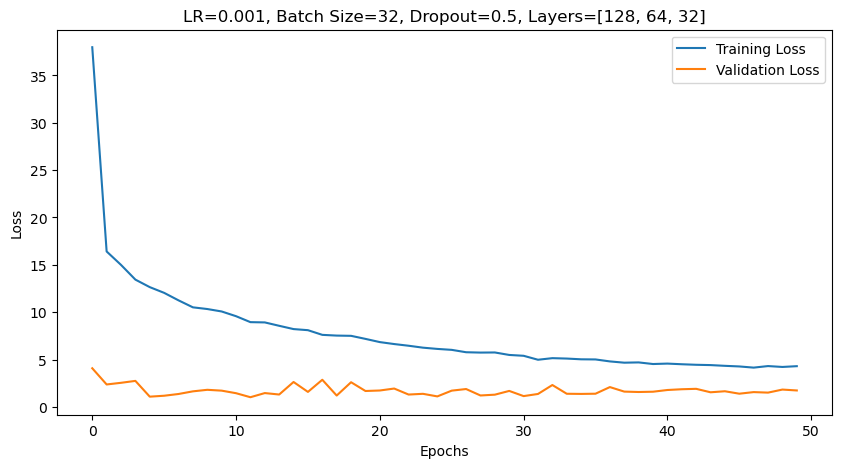

LR=0.01, Batch Size=16, Dropout=0.2, Layers=(64, 32): Final Validation Loss=1.3199
LR=0.01, Batch Size=16, Dropout=0.2, Layers=(128, 64, 32): Final Validation Loss=1.8490
LR=0.01, Batch Size=16, Dropout=0.5, Layers=(64, 32): Final Validation Loss=2.8709
LR=0.01, Batch Size=16, Dropout=0.5, Layers=(128, 64, 32): Final Validation Loss=5.3878
LR=0.01, Batch Size=32, Dropout=0.2, Layers=(64, 32): Final Validation Loss=1.5823
LR=0.01, Batch Size=32, Dropout=0.2, Layers=(128, 64, 32): Final Validation Loss=1.1317
LR=0.01, Batch Size=32, Dropout=0.5, Layers=(64, 32): Final Validation Loss=2.1063
LR=0.01, Batch Size=32, Dropout=0.5, Layers=(128, 64, 32): Final Validation Loss=3.1945
LR=0.001, Batch Size=16, Dropout=0.2, Layers=(64, 32): Final Validation Loss=0.9762
LR=0.001, Batch Size=16, Dropout=0.2, Layers=(128, 64, 32): Final Validation Loss=0.9703
LR=0.001, Batch Size=16, Dropout=0.5, Layers=(64, 32): Final Validation Loss=1.3346
LR=0.001, Batch Size=16, Dropout=0.5, Layers=(128, 64, 32):

In [17]:

# Define hyperparameter grid
learning_rates = [0.01, 0.001]
batch_sizes = [16, 32]
dropout_rates = [0.2, 0.5]  # Add dropout rates
layer_configs = [[64, 32], [128, 64, 32]]  # Add layer configurations
epochs = 50

results = {}

# Loop over hyperparameter combinations
for lr in learning_rates:
    for batch_size in batch_sizes:
        for dropout_rate in dropout_rates:
            for hidden_layers in layer_configs:
                print(f"Training with LR={lr}, Batch Size={batch_size}, Dropout={dropout_rate}, Layers={hidden_layers}")

                # Update DataLoader for batch size
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

                # Initialize model with new hyperparameters
                model = ConfigurableWeatherModel(input_dim, hidden_layers, dropout_rate)
                criterion = nn.MSELoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                # Train the model
                train_losses, val_losses = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, epochs)
                
                # Store results
                results[(lr, batch_size, dropout_rate, tuple(hidden_layers))] = (train_losses, val_losses)

                # Plot Loss vs. Epochs
                plt.figure(figsize=(10, 5))
                plt.plot(train_losses, label="Training Loss")
                plt.plot(val_losses, label="Validation Loss")
                plt.title(f"LR={lr}, Batch Size={batch_size}, Dropout={dropout_rate}, Layers={hidden_layers}")
                plt.xlabel("Epochs")
                plt.ylabel("Loss")
                plt.legend()
                plt.show()

# Compare results for final validation loss
final_losses = {key: val[-1] for key, (_, val) in results.items()}
for key, loss in final_losses.items():
    print(f"LR={key[0]}, Batch Size={key[1]}, Dropout={key[2]}, Layers={key[3]}: Final Validation Loss={loss:.4f}")
